# This gets Masked(green part of) image

In [1]:
def getMask(color_image):
    greenLower = (29, 60, 20)
    greenUpper = (90, 255, 255)
    frame = color_image
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask

# Setup Environment

In [2]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
from mpl_toolkits.mplot3d import Axes3D
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import math
import time
print("Environment Ready")
from numba import cuda
import imutils

Environment Ready


# config camera

In [3]:
pipe = rs.pipeline()
cfg = rs.config()
# cfg.enable_device_from_file("../object_detection.bag")
# profile = pipe.start(cfg)

width = 640
height = 480
fps = 30


cfg.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
cfg.enable_stream(rs.stream.color, width, height, rs.format.bgr8, fps)

profile = pipe.start(cfg)
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)



Depth Scale is:  0.0010000000474974513


# Get 1 frame and show 

In [ ]:
for i in range(50):
    frames = pipe.wait_for_frames()
align = rs.align(rs.stream.color)
frames = align.process(frames)
aligned_depth_frame = frames.get_depth_frame()
depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(frames.get_color_frame().get_data())

# depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

True

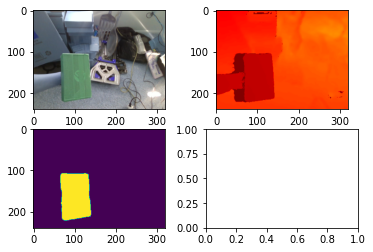

In [12]:
# resize 3 frames
color_image=cv2.resize(color_image,(320,240),interpolation = cv2.INTER_AREA)
depth_image=cv2.resize(depth_image,(320,240),interpolation = cv2.INTER_AREA)
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
maskImage= getMask(color_image)

# show 3 images
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(color_image)
ax[0,1].imshow(depth_colormap)
ax[1,0].imshow(maskImage)

# get distance in meter
depth = depth_image.astype(np.float32)
distance = depth * depth_scale

# save 
cv2.imwrite("filename.jpg", color_image)

In [15]:
distance[190, 30]

0.586

# Test cuda wanyi

In [7]:

#3200 block dim *24 threads

@cuda.jit
def gpu_add(result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    result[y_val, x_val] += 1
#     if idx < n :
#         result[idx] = a[idx] + b[idx]
    if(idx == 320*240-1):
        print(x_val)
        print(y_val)

        
gpu_result = np.zeros((240, 320), dtype = np.float32)
gpu_result_device = cuda.to_device(gpu_result)
blocks_per_grid = 6400
threads_per_block = 12
gpu_add[blocks_per_grid, threads_per_block](gpu_result_device)
cuda.synchronize()


gpu_result = gpu_result_device.copy_to_host()

In [ ]:
plt.imshow(gpu_result*255, cmap='gray', vmin=0, vmax=255)

In [ ]:
plt.imshow(np.zeros((240, 320)), cmap='gray', vmin=0, vmax=255)

# Padding

In [16]:
@cuda.jit
def gpu_pad_helper(input_image, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
#     idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if(y_val!=0 and x_val!=0 and y_val!=239 and x_val!=319):
        if(result[y_val, x_val] == 0):
            if(input_image[y_val-1, x_val-1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val-1, x_val]):
                result[y_val, x_val] = 1
            elif(input_image[y_val-1, x_val+1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val, x_val-1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val, x_val]):
                result[y_val, x_val] = 1
            elif(input_image[y_val, x_val+1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val+1, x_val-1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val+1, x_val]):
                result[y_val, x_val] = 1
            elif(input_image[y_val+1, x_val+1]):
                result[y_val, x_val] = 1

def gpu_padding(maskImage):
    maskImage_device = cuda.to_device(maskImage)
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_pad_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

def gpu_padding_device(maskImage, iterator_number):
    maskImage_device = cuda.to_device(maskImage)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    
    for i in range(iterator_number):
        gpu_result = np.zeros((240, 320), dtype = np.float32)
        gpu_result_device = cuda.to_device(gpu_result)
        gpu_pad_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
        maskImage_device = gpu_result_device
    cuda.synchronize()
    return gpu_result_device

In [17]:
maskImage_padded = maskImage
start = time.time()
for i in range(3):
    maskImage_padded = gpu_padding(maskImage_padded)
print("used time = "+ str(time.time()-start))

used time = 0.4424922466278076


(-0.5, 319.5, 239.5, -0.5)

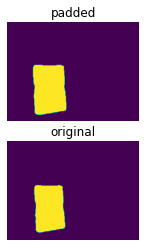

In [18]:
fig, axs = plt.subplots(2)
axs[0].imshow(maskImage_padded)
axs[0].set_title("padded")
axs[0].axis("off")
axs[1].imshow(maskImage)
axs[1].set_title("original")
axs[1].axis("off")

# Inverse pad, pad internel

In [19]:
@cuda.jit
def gpu_pad_inverse_helper(input_image, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
#     idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if(y_val!=0 and x_val!=0 and y_val!=239 and x_val!=319):
        if(result[y_val, x_val] == 1):
            if(input_image[y_val-1, x_val-1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val-1, x_val]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val-1, x_val+1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val, x_val-1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val, x_val]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val, x_val+1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val+1, x_val-1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val+1, x_val]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val+1, x_val+1]==0):
                result[y_val, x_val] = 0

def gpu_padding_inverse(maskImage):
    maskImage_device = cuda.to_device(maskImage)
    gpu_result = np.ones((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_pad_inverse_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

def gpu_padding_inverse_device(maskImage, iterator_number):
    maskImage_device = cuda.to_device(maskImage)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    
    for i in range(iterator_number):
        gpu_result = np.ones((240, 320), dtype = np.float32)
        gpu_result_device = cuda.to_device(gpu_result)
        gpu_pad_inverse_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
        maskImage_device = gpu_result_device
    cuda.synchronize()
    return gpu_result_device

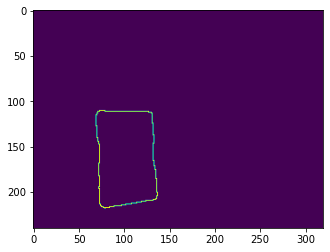

In [37]:
# img = gpu_padding_inverse(maskImage)
# img2 = gpu_padding_inverse(img)
# internal_pad_result_img = gpu_minus(img, img2)
img1 = gpu_padding_inverse_device(maskImage, 3)
img2 = gpu_padding_inverse_device(maskImage, 4)
img = gpu_minus_device(img1, img2)
plt.imshow(img.copy_to_host())

In [38]:
img.copy_to_host()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

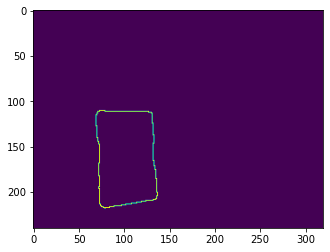

In [39]:
internal_pad_result_img = img
plt.imshow(internal_pad_result_img)

# Draw a warning line

In [26]:
@cuda.jit
def gpu_minus_helper(input_image_minuend, input_image_subtracter, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    result[y_val, x_val] = input_image_minuend[y_val, x_val] - input_image_subtracter[y_val, x_val]
    

def gpu_minus(input_image_minuend, input_image_subtracter):
    input_image_minuend_device = cuda.to_device(input_image_minuend)
    input_image_subtracter_device = cuda.to_device(input_image_subtracter)
    
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_minus_helper[blocks_per_grid, threads_per_block](input_image_minuend_device, input_image_subtracter_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

def gpu_minus_device(input_image_minuend_device, input_image_subtracter_device):
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_minus_helper[blocks_per_grid, threads_per_block](input_image_minuend_device, input_image_subtracter_device, gpu_result_device)
    cuda.synchronize()
    return gpu_result_device

In [27]:
pad_8 = maskImage
pad_8 = gpu_padding_device(pad_8, 8)

pad_9 = pad_8
pad_9 = gpu_padding_device(pad_9, 1)

In [28]:
warning_line_result = gpu_minus_device(pad_9, pad_8)

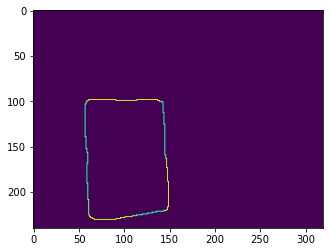

In [30]:
warning_line_result_img = warning_line_result.copy_to_host()
plt.imshow(warning_line_result_img*255)

In [ ]:
plt.imshow(pad_9)

In [ ]:
plt.imshow(pad_8)

In [ ]:
counter0 = 0
counter1 = 0
for x in range(320):
    for y in range(240):
        if(img[y,x]==0):
            counter0+=1
        elif(img[y,x]==1):
            counter1+=1
        else:
            print(img[y,x])

In [ ]:
counter0

In [ ]:
counter1

# Warning Detector

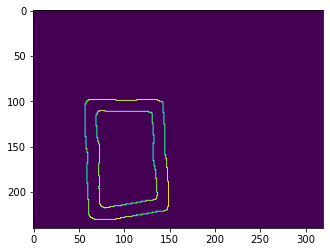

In [40]:
in_bound = internal_pad_result_img
out_bound = warning_line_result_img
plt.imshow(in_bound+out_bound)

In [47]:
temp_img = np.multiply((in_bound+out_bound),distance)

In [48]:
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(temp_img, alpha=0.03), cv2.COLORMAP_JET)

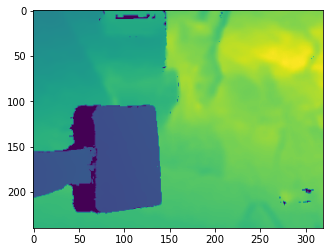

In [50]:
plt.imshow(distance)

In [41]:
in_bound_non_zero_tuple = np.nonzero(in_bound)
out_bound_non_zero_tuple = np.nonzero(out_bound)

1.0

In [58]:
len(out_bound_non_zero_tuple[0])//16

28

In [59]:
import multiprocessing
manager = multiprocessing.Manager()
return_dict = manager.dict()

def worker(lowerBound, upperBound, in_bound_non_zero_tuple, out_bound_non_zero_tuple, distance_map, pixel_diff_in_bound):
    # pixel_diff_in_bound is return_dict
    for in_index in range(lowerBound, upperBound):
        if(in_index%8 == 0):
            in_y = in_bound_non_zero_tuple[0][in_index]
            in_x = in_bound_non_zero_tuple[1][in_index]
            pixel_diff_in_bound[in_index] = float('inf')

            if(distance_map[in_y, in_x]>0):
                for out_index in range(len(out_bound_non_zero_tuple[0])):
                    if(out_index%8 == 0):
                        out_y = out_bound_non_zero_tuple[0][out_index]
                        out_x = out_bound_non_zero_tuple[1][out_index]

                        if(distance_map[out_y, out_x]>0):
                            print("here:"+str(in_index)+" "+str(in_y)+" "+str(in_x)+" "+str(out_y)+" "+str(out_x))
                            if(np.linalg.norm(distance_map[out_y, out_x]-distance_map[in_y, in_x]) < 0.05):
                                dist = np.linalg.norm(np.asarray([out_y, out_x]) - np.asarray([in_y, in_x]))
                                if(dist<pixel_diff_in_bound[in_index]):
                                    pixel_diff_in_bound[in_index] = dist

In [61]:
start = time.time()
num_of_works = len(in_bound_non_zero_tuple[0])
each_worker = num_of_works//16

p0 = multiprocessing.Process(target=worker, args=(0,each_worker,in_bound_non_zero_tuple,out_bound_non_zero_tuple, distance,return_dict,))
p1 = multiprocessing.Process(target=worker, args=(each_worker,each_worker*2,in_bound_non_zero_tuple,out_bound_non_zero_tuple, distance,return_dict,))
p2 = multiprocessing.Process(target=worker, args=(each_worker*2,each_worker*3,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p3 = multiprocessing.Process(target=worker, args=(each_worker*3,each_worker*4,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p4 = multiprocessing.Process(target=worker, args=(each_worker*4,each_worker*5,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p5 = multiprocessing.Process(target=worker, args=(each_worker*5,each_worker*6,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p6 = multiprocessing.Process(target=worker, args=(each_worker*6,each_worker*7,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p7 = multiprocessing.Process(target=worker, args=(each_worker*7,each_worker*8,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p8 = multiprocessing.Process(target=worker, args=(each_worker*8,each_worker*9,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p9 = multiprocessing.Process(target=worker, args=(each_worker*9,each_worker*10,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p10 = multiprocessing.Process(target=worker, args=(each_worker*10,each_worker*11,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p11 = multiprocessing.Process(target=worker, args=(each_worker*11,each_worker*12,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p12 = multiprocessing.Process(target=worker, args=(each_worker*12,each_worker*13,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p13 = multiprocessing.Process(target=worker, args=(each_worker*13,each_worker*14,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p14 = multiprocessing.Process(target=worker, args=(each_worker*14,each_worker*15,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))
p15 = multiprocessing.Process(target=worker, args=(each_worker*15,num_of_works,in_bound_non_zero_tuple,out_bound_non_zero_tuple,distance,return_dict,))

p0.start()
p1.start()
p2.start()
p3.start()
p4.start()
p5.start()
p6.start()
p7.start()
p8.start()
p9.start()
p10.start()
p11.start()
p12.start()
p13.start()
p14.start()
p15.start()

p0.join()
p1.join()
p2.join()
p3.join()
p4.join()
p5.join()
p6.join()
p7.join()
p8.join()
p9.join()
p10.join()
p11.join()
p12.join()
p13.join()
p14.join()
p15.join()
print(time.time()-start)

here:0 110 73 98 61
here:0 110 73 98 69
here:24 111 93 98 69here:0 110 73 98 77here:24 111 93 98 61

here:0 110 73 98 85

here:0 110 73 98 115here:24 111 93 98 77

here:48 111 117 98 61here:0 110 73 98 123here:24 111 93 98 85


here:0 110 73 98 131here:48 111 117 98 69here:24 111 93 98 115


here:72 115 131 98 61here:0 110 73 99 60here:48 111 117 98 77here:24 111 93 98 123



here:72 115 131 98 69here:48 111 117 98 85here:0 110 73 99 97here:24 111 93 98 131


here:88 123 131 98 61here:72 115 131 98 77here:0 110 73 99 105here:24 111 93 99 60




here:48 111 117 98 115here:72 115 131 98 85here:88 123 131 98 69here:24 111 93 99 97here:0 110 73 99 113




here:48 111 117 98 123here:112 134 132 98 61here:72 115 131 98 115here:24 111 93 99 105here:88 123 131 98 77here:0 110 73 100 141





here:48 111 117 98 131here:72 115 131 98 123here:24 111 93 99 113here:88 123 131 98 85here:112 134 132 98 69
here:0 110 73 103 57



here:48 111 117 99 60
here:72 115 131 98 131here:24 111 93 100 141here:8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [103]:
temp = np.asarray(return_dict.values())
np.min(temp)


10.0

**********************************************************************

In [63]:
min_dist = np.zeros(len(in_bound_non_zero_tuple[0]))
return_dict = manager.dict()

for in_index in range(len(in_bound_non_zero_tuple[0])):
    in_y = in_bound_non_zero_tuple[0][in_index]
    in_x = in_bound_non_zero_tuple[1][in_index]
    min_dist[in_index] = float('inf')
    
    if(distance[in_y, in_x]>0):
        
        for out_index in range(len(out_bound_non_zero_tuple[0])):
            out_y = out_bound_non_zero_tuple[0][out_index]
            out_x = out_bound_non_zero_tuple[1][out_index]
#             print(in_y)
#             print(in_x)
#             print(out_y)
#             print(out_x)
            if(distance[out_y, out_x]>0):
                if(np.linalg.norm(distance[out_y, out_x]-distance[in_y, in_x]) < 0.05):
                    dist = np.linalg.norm(np.asarray([out_y, out_x]) - np.asarray([in_y, in_x]))
                    if(dist<min_dist[in_index]):
                        min_dist[in_index] = dist
    else:
        pass
#         print(distance[in_y, in_x])


In [65]:
min_dist

array([10.        , 10.        , 10.        , 10.        ,         inf,
               inf,         inf,         inf,         inf,         inf,
       10.19803903, 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.19803903, 10.44030651, 10.44030651, 10.44030651, 10.44030651,
       10.44030651, 10.19803903, 10.19803903, 10.        , 10.        ,
       56.92099788, 55.36244214, 55.71355311, 56.08029957,         inf,
               inf,         inf,         inf, 11.18033989, 11.04536102,
       11.        , 11.        , 11.        , 11.        , 10.77032961,
       36.68787266, 18.86796226, 10.04987562, 10.        , 10.        ,
       10.19803903, 10.04987562, 10.19803903, 10.44030651, 10.19803903,
       12.20655562, 11.        , 11.        , 11.18033989, 13.03840481,
       13.60147051, 14.2126704 , 14.86606875, 15.55634919, 16.2788206 ,
       17.02938637, 58.18075283,         inf,         inf,      

In [36]:
distance

array([[0.42700002, 0.42800003, 0.43      , ..., 0.        , 0.        ,
        0.        ],
       [0.42700002, 0.42900002, 0.43      , ..., 0.        , 0.        ,
        0.        ],
       [0.42800003, 0.42900002, 0.43      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.44200003, 0.441     , 0.441     , ..., 0.        , 0.        ,
        0.        ],
       [0.44000003, 0.44000003, 0.439     , ..., 0.        , 0.        ,
        0.        ],
       [0.439     , 0.439     , 0.43800002, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [41]:
out_bound_non_zero_tuple[0][0]

89